# 🧠 Age, Gender & Ethnicity Prediction

**Multi-Head CNN using Pandas + TensorFlow approach**

---

## 📦 Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



2026-02-02 00:35:28.470712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769992528.660599      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769992528.717601      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769992529.185249      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769992529.185284      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769992529.185286      55 computation_placer.cc:177] computation placer alr

## ⚙️ Configuration

In [2]:
CSV_PATH = '/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv'

IMG_SIZE = 64 
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 30
LEARNING_RATE = 1e-3

## 📂 Load and Split Data using Pandas

In [3]:
print("📖 Loading CSV...")
df = pd.read_csv(CSV_PATH)

df.head()

📖 Loading CSV...


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

total_samples = len(df)
train_size = int(0.70 * total_samples)
val_size = int(0.15 * total_samples)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

print("📊 Data Split:")
print(f"   Train: {len(train_df):,} samples")
print(f"   Val:   {len(val_df):,} samples")
print(f"   Test:  {len(test_df):,} samples")

📊 Data Split:
   Train: 16,593 samples
   Val:   3,555 samples
   Test:  3,557 samples


## 🖼️ Image Preprocessing Functions

In [5]:
def load_image_from_pixels(pixels_str):
    pixels = tf.strings.split(pixels_str, ' ')
    pixels = tf.strings.to_number(pixels, out_type=tf.float32)
    image = tf.reshape(pixels, [48, 48, 1])
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    
    return image


In [6]:
def process_row(pixels_str, age, gender, ethnicity):

    image = load_image_from_pixels(pixels_str)
    
    labels = {
        "age": age,
        "gender": gender,
        "ethnicity": ethnicity
    }
    
    return image, labels



## 🔄 Create TensorFlow Datasets

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_df["pixels"].values,
        train_df["age"].values,
        train_df["gender"].values,
        train_df["ethnicity"].values
    )
)

train_ds = (
    train_ds
    .map(process_row, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print(f"✅ Train dataset created: {len(train_df):,} samples")

I0000 00:00:1769992545.585156      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769992545.591036      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Train dataset created: 16,593 samples


In [8]:
val_ds = tf.data.Dataset.from_tensor_slices(
    (
        val_df["pixels"].values,
        val_df["age"].values,
        val_df["gender"].values,
        val_df["ethnicity"].values
    )
)

val_ds = (
    val_ds
    .map(process_row, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print(f"✅ Validation dataset created: {len(val_df):,} samples")

✅ Validation dataset created: 3,555 samples


In [9]:
test_ds = tf.data.Dataset.from_tensor_slices(
    (
        test_df["pixels"].values,
        test_df["age"].values,
        test_df["gender"].values,
        test_df["ethnicity"].values
    )
)

test_ds = (
    test_ds
    .map(process_row, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print(f"✅ Test dataset created: {len(test_df):,} samples")

✅ Test dataset created: 3,557 samples


## 🔍 Verify Dataset

In [10]:
batch = next(iter(train_ds))
images, labels = batch

print("\n" + "="*60)
print("BATCH VERIFICATION")
print("="*60)
print(f"Images shape: {images.shape}")
print(f"Age sample: {labels['age'][0].numpy()}")
print(f"Gender sample: {labels['gender'][0].numpy()}")
print(f"Ethnicity sample: {labels['ethnicity'][0].numpy()}")
print("="*60)


BATCH VERIFICATION
Images shape: (32, 64, 64, 3)
Age sample: 20
Gender sample: 0
Ethnicity sample: 1


## 🎨 Visualize Data

In [11]:
def visualize_batch(dataset, n=16):
    gender_map = {0: 'Male', 1: 'Female'}
    ethnicity_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
    
    images, labels = next(iter(dataset))
    
    grid_size = int(np.ceil(np.sqrt(n)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle('Training Data Samples', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        
        age = labels['age'][i].numpy()
        gender = labels['gender'][i].numpy()
        ethnicity = labels['ethnicity'][i].numpy()
        
        title = f"Age: {age}\n"
        title += f"{gender_map.get(gender, 'Unknown')}\n"
        title += f"{ethnicity_map.get(ethnicity, 'Unknown')}"
        axes[i].set_title(title, fontsize=9)
    
    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


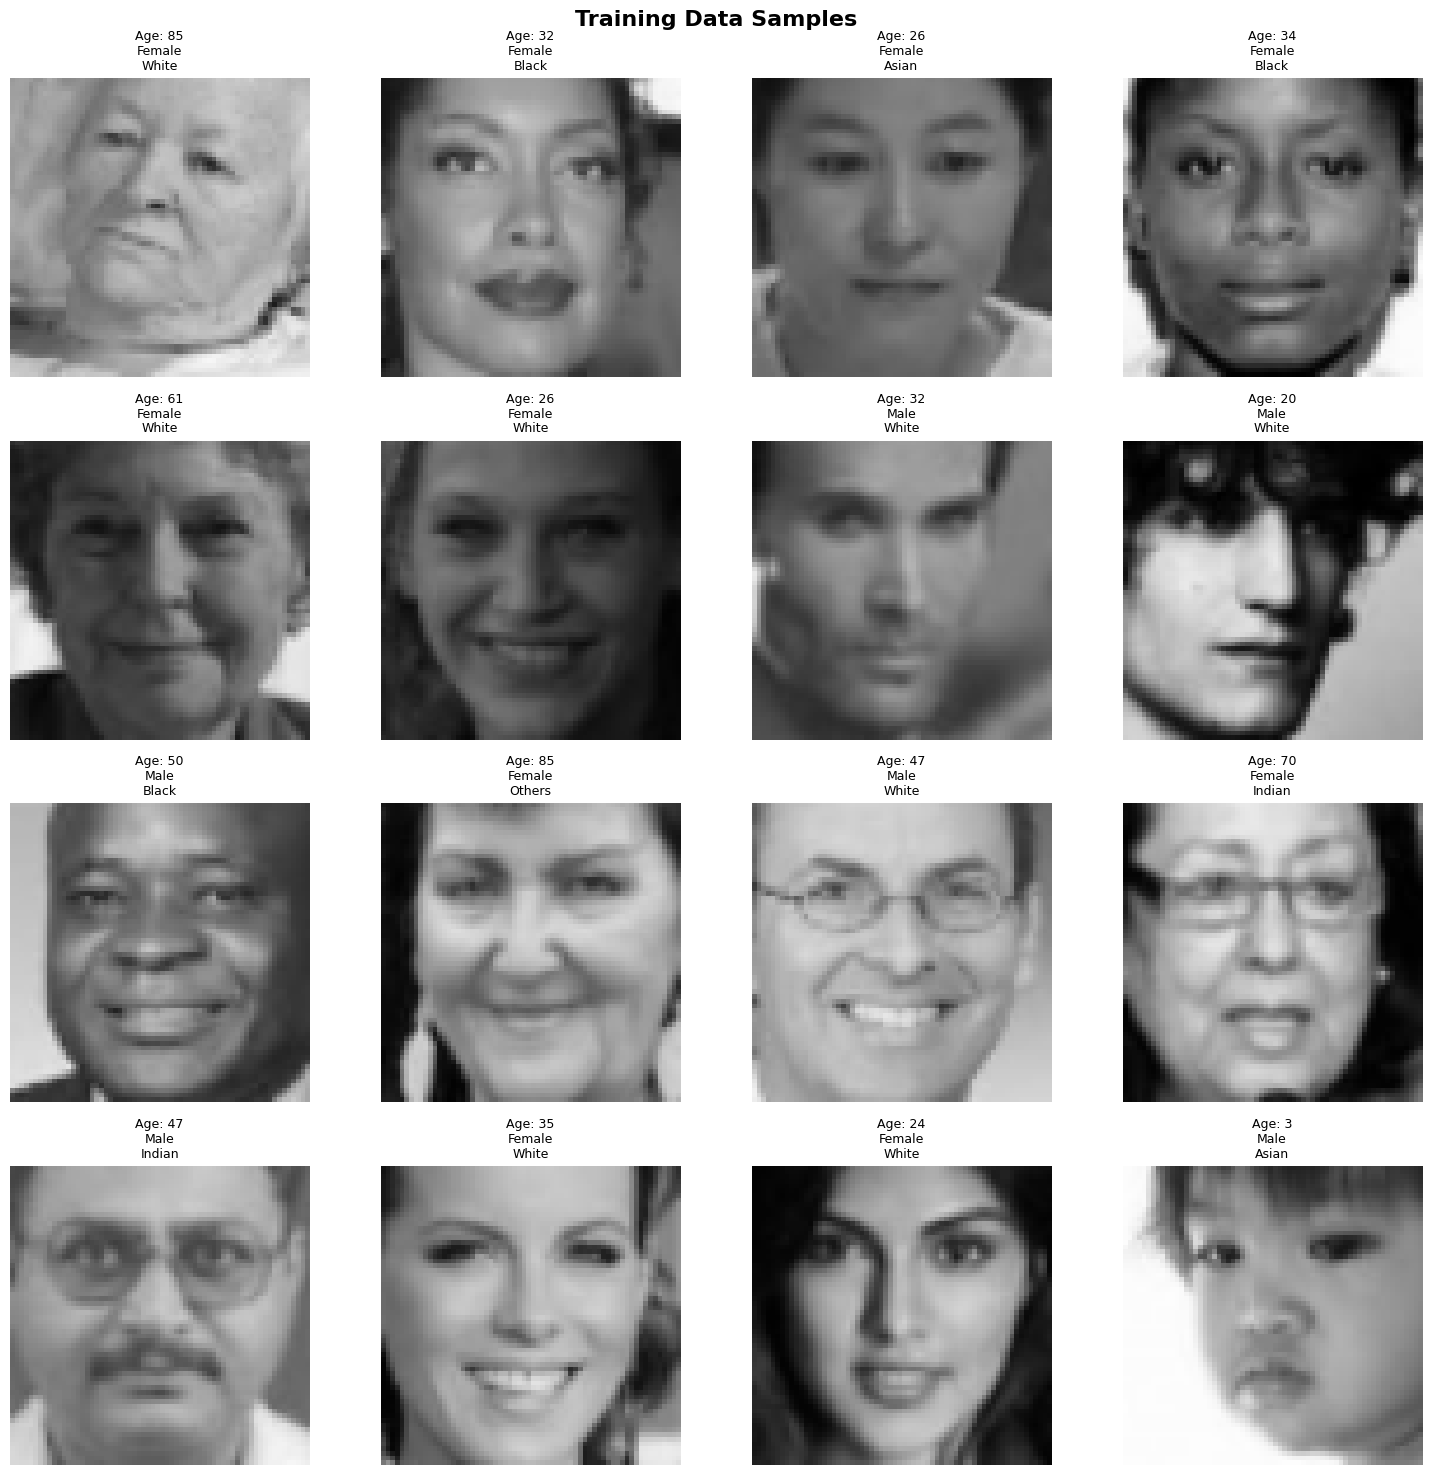

In [12]:
visualize_batch(train_ds, n=16)

## 🏗️ Build Multi-Head CNN Model

In [13]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

age_output = layers.Dense(1, activation="linear", name="age")(x)

gender_output = layers.Dense(1, activation="sigmoid", name="gender")(x)

ethnicity_output = layers.Dense(5, activation="softmax", name="ethnicity")(x)

model = models.Model(
    inputs=inputs,
    outputs=[age_output, gender_output, ethnicity_output]
)


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,097,408 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ethnicity (Dense)   │ (None, 5)         │      1,285 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,192,455 (8.36 MB)

 Trainable params: 2,192,455 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

## ⚙️ Compile Model

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss={
        "age": "mae",
        "gender": "binary_crossentropy",
        "ethnicity": "sparse_categorical_crossentropy"
    },
    metrics={
        "age": ["mae"],
        "gender": ["accuracy"],
        "ethnicity": ["accuracy"]
    }
)



## 🎯 Training Callbacks

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_multihead_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    verbose=1
)



## 🚀 Train Model

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)


Epoch 1/30


I0000 00:00:1769992551.096028     134 service.cc:152] XLA service 0x7d83d4010b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769992551.096070     134 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769992551.096075     134 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769992551.613326     134 cuda_dnn.cc:529] Loaded cuDNN version 91002


 19/519 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - age_loss: 24.8190 - age_mae: 24.8190 - ethnicity_accuracy: 0.2632 - ethnicity_loss: 2.6581 - gender_accuracy: 0.4851 - gender_loss: 1.1052 - loss: 28.5823

I0000 00:00:1769992555.009357     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - age_loss: 16.7758 - age_mae: 16.7758 - ethnicity_accuracy: 0.3266 - ethnicity_loss: 2.2120 - gender_accuracy: 0.5501 - gender_loss: 0.9205 - loss: 19.9082
Epoch 1: val_loss improved from inf to 13.68260, saving model to best_multihead_model.keras
519/519 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - age_loss: 16.7724 - age_mae: 16.7724 - ethnicity_accuracy: 0.3267 - ethnicity_loss: 2.2112 - gender_accuracy: 0.5502 - gender_loss: 0.9202 - loss: 19.9037 - val_age_loss: 11.8740 - val_age_mae: 11.8770 - val_ethnicity_accuracy: 0.5353 - val_ethnicity_loss: 1.2652 - val_gender_accuracy: 0.7404 - val_gender_loss: 0.5406 - val_loss: 13.6826 - learning_rate: 0.0010
Epoch 2/30
513/519 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - age_loss: 11.5997 - age_mae: 11.5997 - ethnicity_accuracy: 0.4923 - ethnicity_loss: 1.3152 - gender_accuracy: 0.7235 - gender_loss: 0.5411 - loss: 13.4560
Epoch 2: val_loss improved from 13.68260 to 11.71178, saving model to best_multihead_model.

## 📊 Plot Training History

In [18]:
def plot_history(history, metric):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[f'{metric}'], label=f'Train {metric}', linewidth=2)
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}', linewidth=2)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.title(f'{metric.capitalize()} over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()


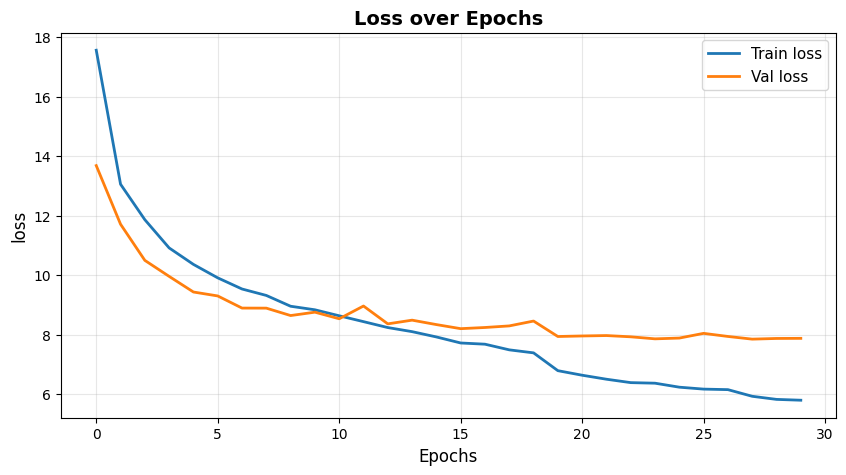

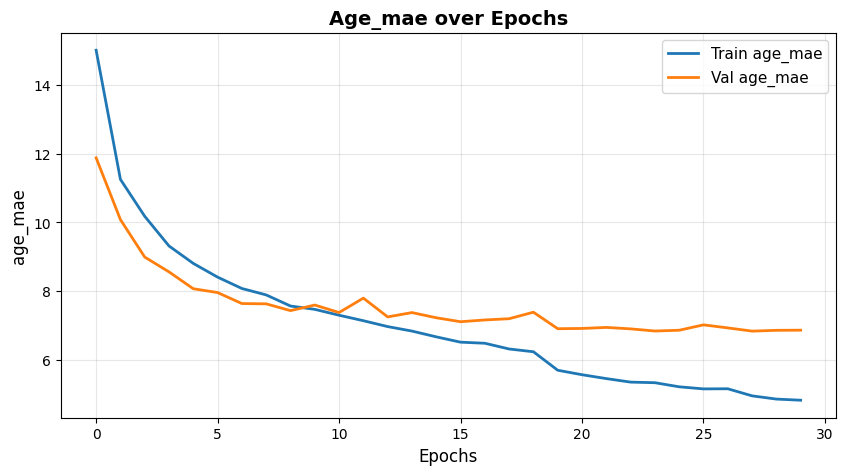

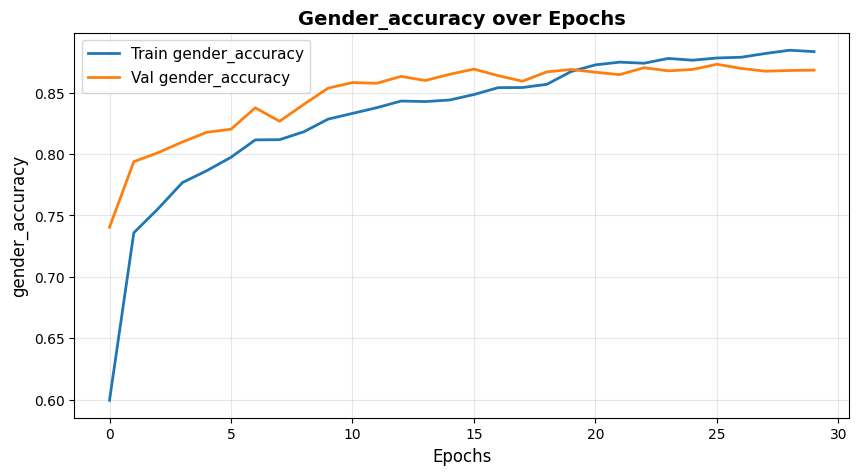

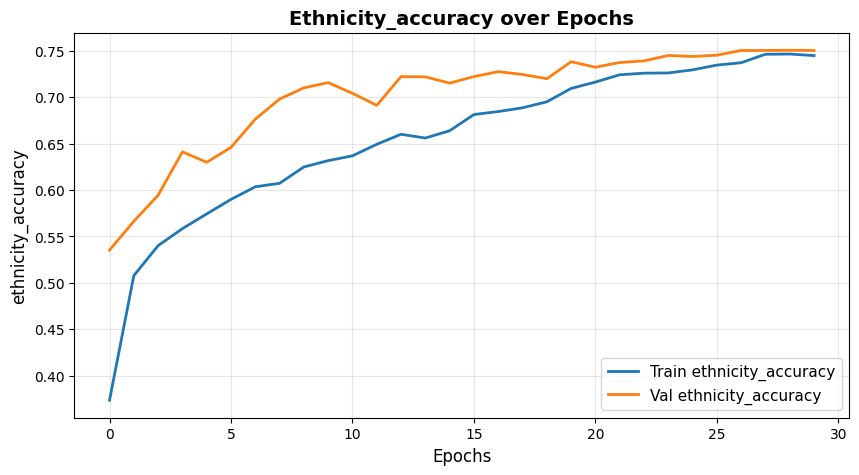

In [19]:

plot_history(history, "loss")

heads = ["age", "gender", "ethnicity"]
for head in heads:
    if head == "age":
        plot_history(history, f"{head}_mae")
    else:
        plot_history(history, f"{head}_accuracy")


## 🧪 Evaluate on Test Set

In [20]:

results = model.evaluate(test_ds, return_dict=True)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
for k, v in results.items():
    print(f"{k}: {v:.4f}")
print("="*60)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - age_loss: 7.2463 - age_mae: 7.2457 - ethnicity_accuracy: 0.7592 - ethnicity_loss: 0.7069 - gender_accuracy: 0.8916 - gender_loss: 0.2497 - loss: 8.2023

TEST SET RESULTS
age_loss: 7.1325
age_mae: 7.1003
ethnicity_accuracy: 0.7622
ethnicity_loss: 0.7007
gender_accuracy: 0.8811
gender_loss: 0.2561
loss: 8.0584


## 🔮 Make Predictions

In [21]:
def visualize_predictions(images, labels, preds, n=6):

    gender_map = {0: 'Male', 1: 'Female'}
    ethnicity_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
    
    cols = 3  
    rows = int(np.ceil(n / cols)) 
    
    plt.figure(figsize=(18, rows * 3))  
    
    for i in range(n):
        plt.subplot(rows, cols, i+1)  
        plt.imshow(images[i])
        plt.axis("off")
        
        true_age = labels['age'][i].numpy()
        true_gender = labels['gender'][i].numpy()
        true_ethnicity = labels['ethnicity'][i].numpy()
        
        pred_age = preds[0][i][0]
        pred_gender = 1 if preds[1][i][0] > 0.5 else 0
        pred_ethnicity = np.argmax(preds[2][i])
        
        age_error = abs(pred_age - true_age)
        gender_correct = "✅" if pred_gender == true_gender else "❌"
        ethnicity_correct = "✅" if pred_ethnicity == true_ethnicity else "❌"
        
        title = f"GT: Age {true_age} | {gender_map[true_gender]} | {ethnicity_map[true_ethnicity]}\n"
        title += f"Pred: Age {pred_age:.0f} (±{age_error:.0f}) | {gender_map[pred_gender]} {gender_correct} | {ethnicity_map[pred_ethnicity]} {ethnicity_correct}"
        
        plt.title(title, fontsize=8)
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


/tmp/ipykernel_55/1732164074.py:33: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/1732164074.py:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


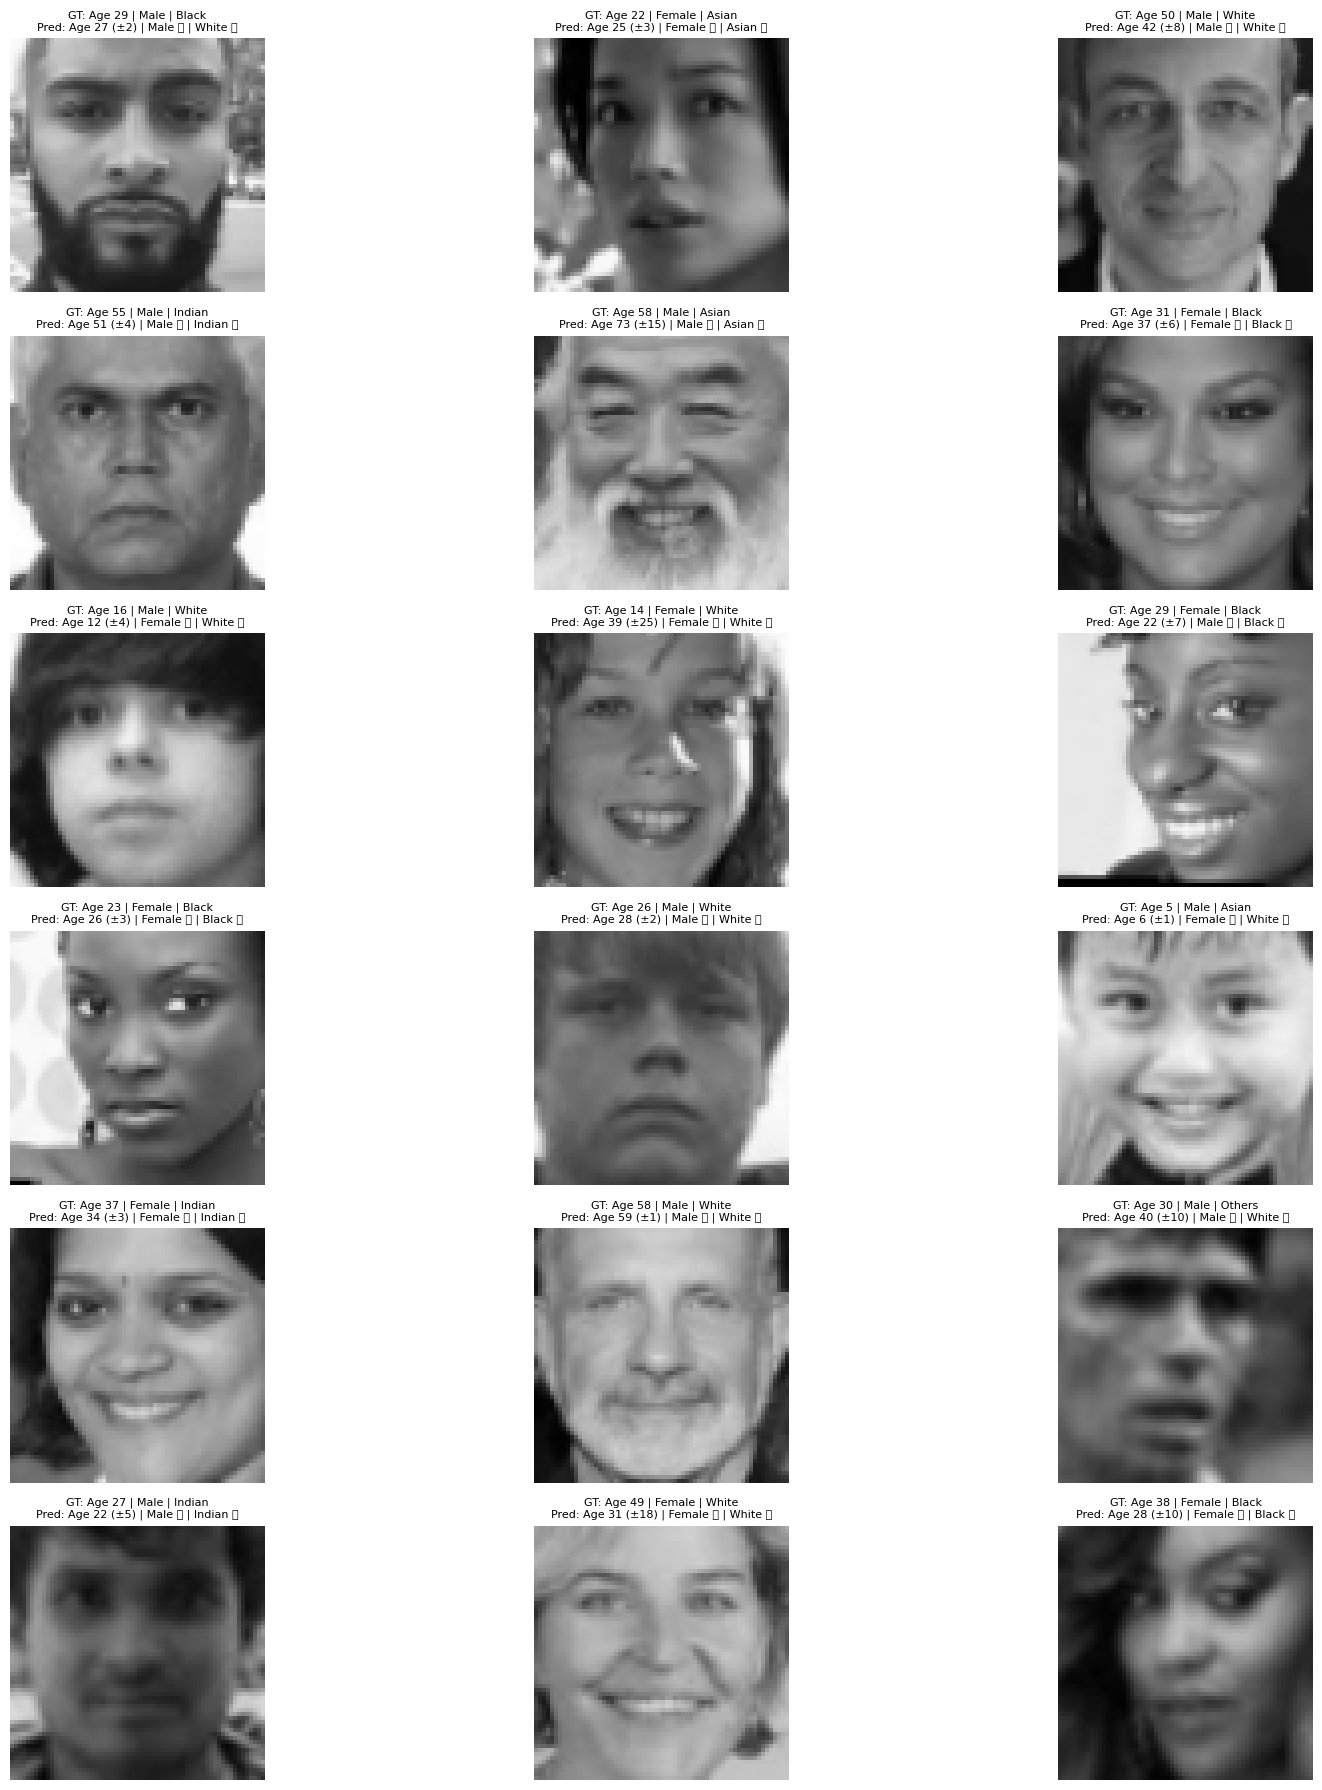

In [22]:
images, labels = next(iter(test_ds))
preds = model.predict(images)

visualize_predictions(images, labels, preds, n=18)

In [23]:
model.save('final_age_gender_ethnicity_model.keras')
